_______________
# Table of contents
## Von Neumann
1. [One Run](#onerun)
2. [On-demand mode](#on_demand) 
3. [Fully Streaming Mode](#fullystreaming)
4. [Another Implementation of the Streaming Mode](#fullystreaming2)
5. [Executing on Quantum Processors](#qucomp)
6. [Initial Concurrence](#initconc)

## Elias
1. [Measuring the Hamming weight of 3 qubits](#Elias_simulation)
2. [Executing on a Simulator and Quantum Processor ](#Elias_quant_Melbourne)
3. [Initial Concurrence](#init_conc_Elias)
_______________
#### Execute the next cell first

In [2]:
from qiskit import *
import math
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram
import numpy as np
from scipy.special import binom as binom_coef
from scipy.stats import binom
from qiskit.tools.monitor import job_monitor
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sns.set(style="whitegrid", context="paper", palette="colorblind")

_______________
## 1. One Run <a id='onerun'></a>
#### Generating two partially entangled states and executing VN once

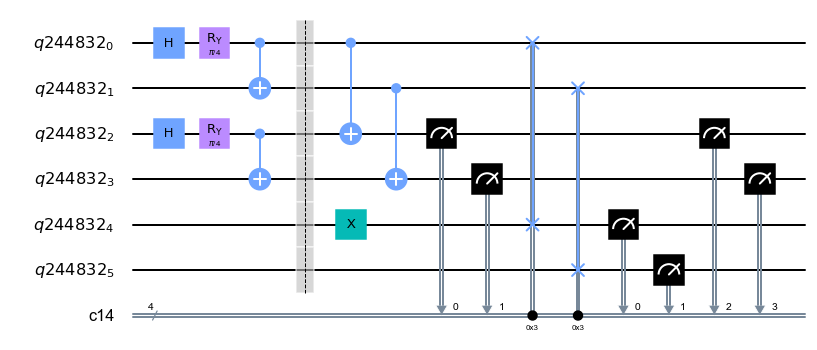

In [71]:
theta = math.pi / 4 # choose theta between -pi/2 and pi/2

# creating the initial entangled state
qr = QuantumRegister(6)
cr = ClassicalRegister(4)
circuit = QuantumCircuit(qr, cr)
circuit.h([0,2])
circuit.ry(theta, [0, 2])

# visualization of the rotation around the y-axis

# simulator = Aer.get_backend('statevector_simulator')
# result = execute(circuit, backend = simulator).result()
# statevector  = result.get_statevector()
# plot_bloch_multivector(statevector) 

circuit.cx([0, 2], [1, 3])
circuit.barrier()
circuit.x(4)
circuit.cx([0, 1], [2, 3])
circuit.measure([2, 3], [0, 1])
circuit.swap([0, 1], [4, 5]).c_if(cr, 3)
circuit.measure([4, 5, 2, 3], [0,1, 2, 3])

circuit.draw(output='mpl')


#### Execute VN on the simulator and plot histogram

{'0001': 49197, '1100': 8235, '1111': 8104}


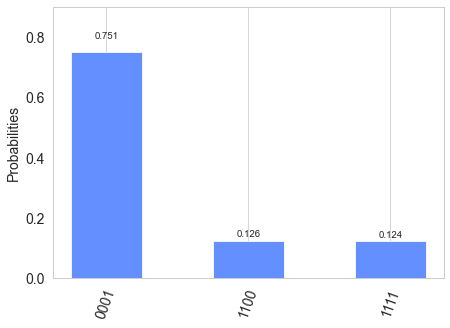

In [72]:
simulator = Aer.get_backend('qasm_simulator')
shots = 2 ** 16
result = execute(circuit, backend = simulator, shots=shots).result()
print(result.get_counts(circuit))
plot_histogram(result.get_counts(circuit))


# 2. On-demand Mode <a id='on_demand'></a>
The following blocks execute Von Neumann's protocol for varying numbers of iterations and theta, and check what the probability of succeeding at least once is (with 95% confidence intervals). This probability is plotted and compared to the theoretical binomial distribution. 

In [73]:
results = []
for N in range(1, 7):
    for theta in np.linspace(-math.pi / 2, math.pi / 2, 7):
    # divide the interval -pi/2 to pi/2 in 7 data points, including the boundaries

        # creating the initial entangled state
        qr = QuantumRegister(6)
        cr = ClassicalRegister(2)
        circuit = QuantumCircuit(qr, cr)
        circuit.h([0,2])
        circuit.ry(theta, [0, 2])

        circuit.cx([0, 2], [1, 3])
        circuit.barrier()
        circuit.x(4)
        circuit.cx([0, 1], [2, 3])
        circuit.measure([2, 3], [0, 1])
        circuit.swap([0, 1], [4, 5]).c_if(cr, 3)
        circuit.measure([4, 5], [0,1])

        circuit.draw(output='mpl')
        for _ in range(8192):
            simulator = Aer.get_backend('qasm_simulator')
            shots = N
            result = execute(circuit, backend = simulator, shots=shots).result()
            success = int('11' in result.get_counts(circuit) or '00' in result.get_counts(circuit))
            results.append((N, theta, success))

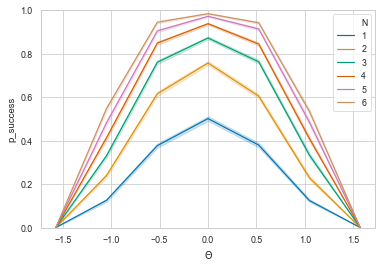

In [ ]:
data = pd.DataFrame(results, columns=["N", "theta", "p_success"])
data["N"] = data["N"].astype("category")
sns.lineplot(x="theta", y="p_success", hue="N", data=data)
plt.ylim(0, 1)
plt.xlabel("$\Theta$")
plt.savefig('VN_on_demand.pdf')


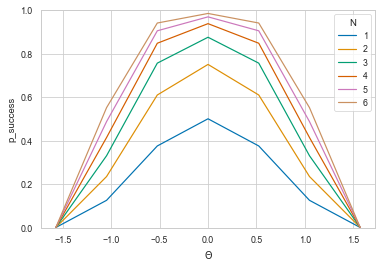

In [3]:
for N in range(1, 7):
    theta = np.linspace(-math.pi / 2, math.pi / 2, 7)
    p_0 = ((np.cos(theta / 2) - np.sin(theta / 2)) / math.sqrt(2)) ** 2
    p_1 = ((np.cos(theta / 2) + np.sin(theta / 2)) / math.sqrt(2)) ** 2
    p = 2 * p_0 * p_1
    if N == 1:
        p_success = p
    else:
        p_success = 1 - binom_coef(N, 0) * (1 - p) ** (N)
    plt.plot(theta, p_success, label=N)
    plt.ylim(0, 1)
    plt.legend()
plt.legend(title="N")
plt.ylabel("p_success")
plt.xlabel("$\Theta$")
plt.savefig('VN_on_demand_binom.pdf')


_______________
## 3. Running VN Multiple Times, fully streaming mode <a id='fullystreaming'></a>

In [ ]:
theta = math.pi / 4 #choose theta between -pi/2 and pi/2
N = 12 # nr of bits we want to read, should be a multiple of 4

_, ax = plt.subplots(1, N // 4, figsize=(20, 6))

for k in range(4, N + 4, 4):
    qr = QuantumRegister(3 * k // 2, 'q')
    cr = ClassicalRegister(2, 'c')
    output = ClassicalRegister(k // 2)
    circuit = QuantumCircuit(qr, cr, output)
    for i in range(k, 3 * k // 2, 2):
        circuit.x(qr[i])
    for i in range(0, k, 4):
        circuit.h([i,i + 2])
        circuit.ry(theta, [i, i + 2])
        circuit.cx([i, i + 2], [i + 1, i + 3])
        circuit.barrier()
        circuit.cx([i, i + 1], [i + 2, i + 3])
        circuit.measure([i + 2, i + 3], [0, 1])
        circuit.barrier()
        for j in range(i // 4, 0, -1): 
            circuit.swap([k + 2 * (j - 1), k + 2 * (j - 1) + 1], [k + 2 * (j - 1) + 2, k + 2 * (j - 1) + 3]).c_if(cr, 3)
        circuit.swap([i, i + 1], [k, k + 1]).c_if(cr, 3)
        circuit.barrier()
    circuit.measure(qr[k:(3 * k // 2)], output[:k // 2])
    simulator = Aer.get_backend('qasm_simulator', precision='single')
    shots = 100
    result = execute(circuit, backend = simulator, shots=shots).result()
#     if k == 12:
#         bar_labels = False
#     else:
#         bar_labels = True
    bar_labels = True
    plot_histogram(result.get_counts(circuit), ax=ax[k//4 - 1], bar_labels=bar_labels)

    plt.tight_layout()

    %matplotlib inline
circuit.draw(output='mpl')

# plt.savefig('VN_streaming.pdf')
    

_______________
## 4. Another Implementation of the Streaming Mode <a id='fullystreaming2'></a>
The next block creates a barplot of the number of successes of Von Neumann’s protocol on the simulator and the theoretical binomial distribution with p = 0.25.



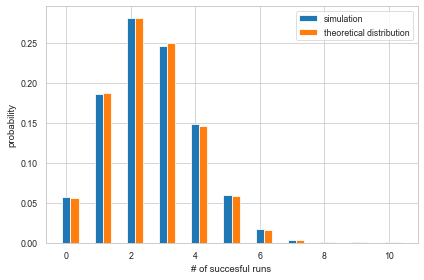

In [5]:
sns.set(style="whitegrid", context="paper", palette="tab10")

theta = math.pi / 4 #choose theta between -pi/2 and pi/2
N = 100000
shots = 10
succes = []
# creating the initial entangled state
qr = QuantumRegister(6)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)
circuit.h([0,2])
circuit.ry(theta, [0, 2])

# visualization of the rotation around the y-axis
simulator = Aer.get_backend('statevector_simulator')
result = execute(circuit, backend = simulator).result()
statevector  = result.get_statevector()
plot_bloch_multivector(statevector) 

circuit.cx([0, 2], [1, 3])
circuit.barrier()
circuit.x(4)
circuit.cx([0, 1], [2, 3])
%matplotlib inline
circuit.draw(output='mpl')
circuit.measure([2, 3], [0, 1])
circuit.swap([0, 1], [4, 5]).c_if(cr, 3)
circuit.measure([4, 5], [0,1])

for i in range(N):
    simulator = Aer.get_backend('qasm_simulator')
    shots = shots
    result = execute(circuit, backend = simulator, shots=shots).result()
    zeroes = int(result.get_counts(circuit).get('00') or 0)
    ones = int(result.get_counts(circuit).get('11') or 0)
    succes.append(zeroes + ones)
#     succes.append(zeroes)
 
succes_counts = np.bincount(succes, minlength=11)
barwidth = 0.25
r1 = np.arange(len(succes_counts))
r2 = [x + barwidth for x in r1]
plt.bar(r1, succes_counts / N, width=barwidth, label='simulation')
plt.bar(r2, binom.pmf(range(len(succes_counts)), 10, 0.250), width=barwidth, label='theoretical distribution')

plt.legend()
plt.xlabel('# of succesful runs')
plt.ylabel('probability')
plt.tight_layout()
plt.savefig("VN_10_runs.pdf")

_______________
## 5. Executing on Quantum Processors <a id='qucomp'></a>
#### Insert your API token to acces IBM Quantum devices via ```IBMQ.save_account()```

In [ ]:
IBMQ.save_account('XXX')

In [ ]:
theta = 3 * math.pi / 4 #choose theta between -pi/2 and pi/2
shots = 8192

# creating the initial entangled state
qr = QuantumRegister(4, 'q')
cr = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qr, cr)
# circuit.h([0,2])
# circuit.ry(theta, [0, 2])

circuit.rx(theta, [0,2])
circuit.cx([0, 2], [1, 3])
circuit.barrier()
circuit.cx([0, 1], [2, 3])

circuit.measure([0, 1, 2, 3], [0, 1, 2, 3])

circuit.draw(output='mpl')
# circuit.draw(output='mpl', filename='Von_Neumann_real_qubits_0.pdf')

#### Executing circuit on the simulator for comparison

In [ ]:
_, ax = plt.subplots(figsize=(10, 5))
simulator = Aer.get_backend('qasm_simulator', precision='single')
result = execute(circuit, backend = simulator, shots=shots).result()
print(result.get_counts(circuit))
plot_histogram(result.get_counts(circuit), ax=ax)
plt.tight_layout()

# plt.savefig('VN_real_qubits_pi_4_results.pdf')

#### Executing circuit on the quantum computer of your choice
An overview of the available quantum computers: https://quantum-computing.ibm.com/

In [ ]:
IBMQ.load_account()

In [ ]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_santiago') # get the backend you want to execute your circuit on
job = execute(circuit, backend=qcomp, shots=shots)

In [ ]:
job_monitor(job) 

In [ ]:
result = job.result()
_, ax = plt.subplots(figsize=(10, 5))
plot_histogram(result.get_counts(circuit), ax=ax)
plt.tight_layout()

# plt.savefig('VN_real_qubits_santiago_pi_4_2.pdf')

_______________
## 6. Initial Concurrence <a id='initconc'></a>

In [ ]:
from qiskit import *
import math
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
%matplotlib inline
import matplotlib.pyplot as plt

#calculating the initial concurrence
theta = math.pi / 3 #choose theta between -pi/2 and pi/2

# creating the initial entangled state
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qr, cr)
circuit.h(0)
circuit.ry(theta, 0)
circuit.cx(0, 1)

circuit.measure([0,1], [0,1])

circuit.draw('mpl')

In [ ]:
simulator = Aer.get_backend('qasm_simulator', precision='single')
shots = 100000
result = execute(circuit, backend = simulator, shots=shots).result()
print(result.get_counts(circuit))
plot_histogram(result.get_counts(circuit))

# plt.savefig('VN_init_conc_sim_pi_6.pdf')

In [8]:
IBMQ.load_account()

/Users/niv/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
shots = 8192
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_santiago')
job = execute(circuit2, backend=qcomp, shots=shots)


In [ ]:
job_monitor(job)


In [ ]:
result = job.result()
_, ax = plt.subplots(figsize=(10, 5))
plot_histogram(result.get_counts(circuit2), ax=ax)
plt.tight_layout()

# plt.savefig('VN_init_conc_yorktown_pi_6.pdf')


In [ ]:
print(result.get_counts(circuit2))


___________________________________________________
___________________________________________________
# Elias's Protocol
## 1. Measuring the Hamming weight of 3 qubits <a id='Elias_simulation'></a>

In the following cell, we define two functions that respectively implement the half adder and the measures the Hamming weight for the simulator. Next we check if our implementation of the Hamming weight circuit works for 3 qubits. 

#### Note that the next cell needs to be executed in order to run the other cells in this chapter

In [7]:
sns.reset_orig()

def half_adder(carry, ancilla, zero):
    circuit.ccx(carry, ancilla, zero)
    circuit.cx(carry, ancilla)
    circuit.swap(carry, zero)
    circuit.barrier()
    
def hamming_weight(qubits, carry, ancillas, zeroes, swap_nr):
    N = len(qubits)
    for i in range(N):
        circuit.cx(qubits[i], carry)
        for j in range(min(i + 1, len(ancillas))):
            half_adder(carry, ancillas[j], zeroes[swap_nr])
            swap_nr += 1

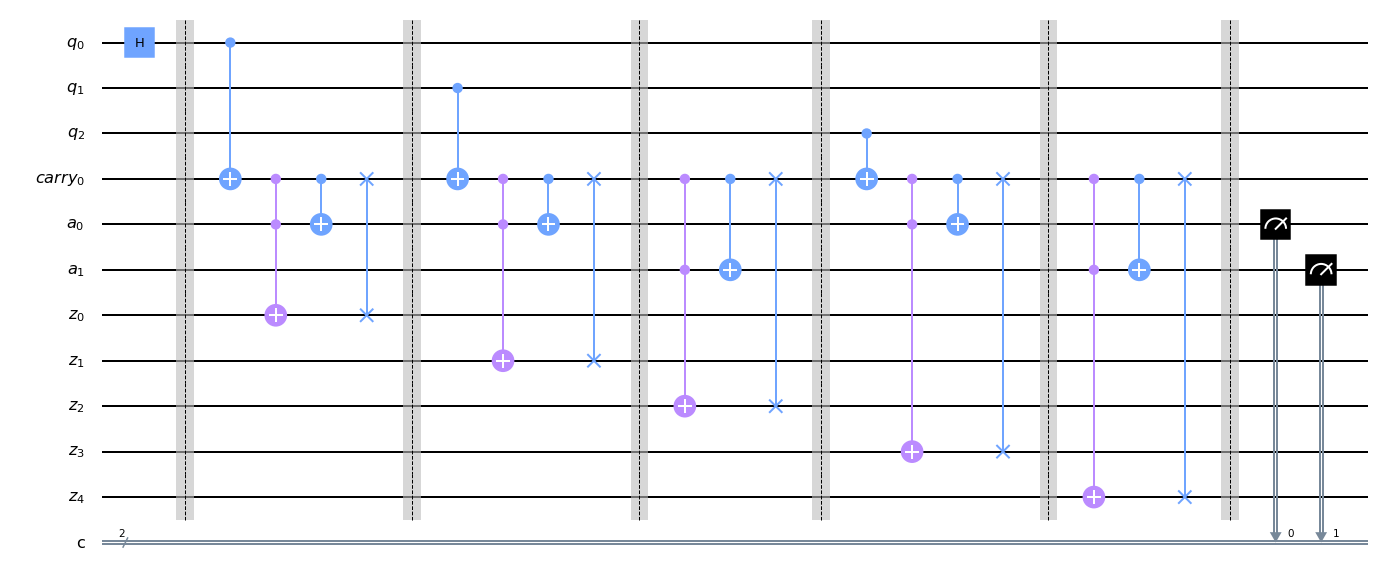

In [52]:
N = 3 # number of qubits that we want to measure the Hamming weight of

qr = QuantumRegister(N, 'q')
carry = QuantumRegister(1, 'carry')
ancilla_A = QuantumRegister(2, 'a')
zeroes = QuantumRegister(5, 'z')
cr = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qr, carry, ancilla_A, zeroes, cr)

# initialize the states of the qubits: by applying an X-gate the qubit is flipped
circuit.h(0) 

circuit.barrier()

hamming_weight([0, 1, 2], carry, ancilla_A, zeroes, 0)

circuit.measure(ancilla_A, cr)
circuit.draw(output='mpl', fold=40, filename='test_hamming_weight.pdf')


{'00': 5017, '01': 4983}


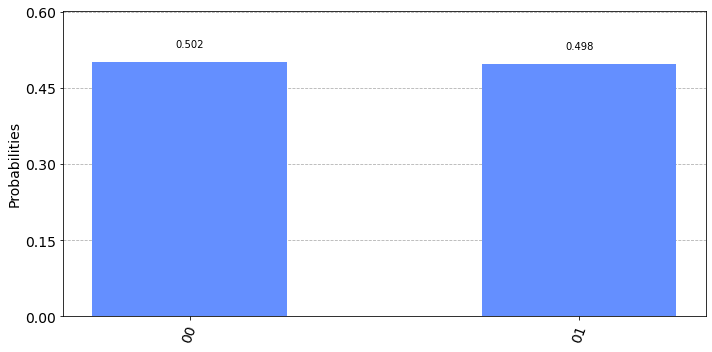

In [53]:
shots = 10000
_, ax = plt.subplots(figsize=(10, 5))
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend = simulator, shots=shots).result()
print(result.get_counts(circuit))
plot_histogram(result.get_counts(circuit), ax=ax)
plt.tight_layout()


_______________________________________
## 2. Executing on a Simulator and Quantum Processor <a id='Elias_quant_Melbourne'></a>
In the next cells, we execute Elias's protocol for N = 2 on the simulator and the 15-qubit processor Melbourne. Since we cannot perform a RESET operation, we have to SWAP with qubits whenever we need a RESET operation.

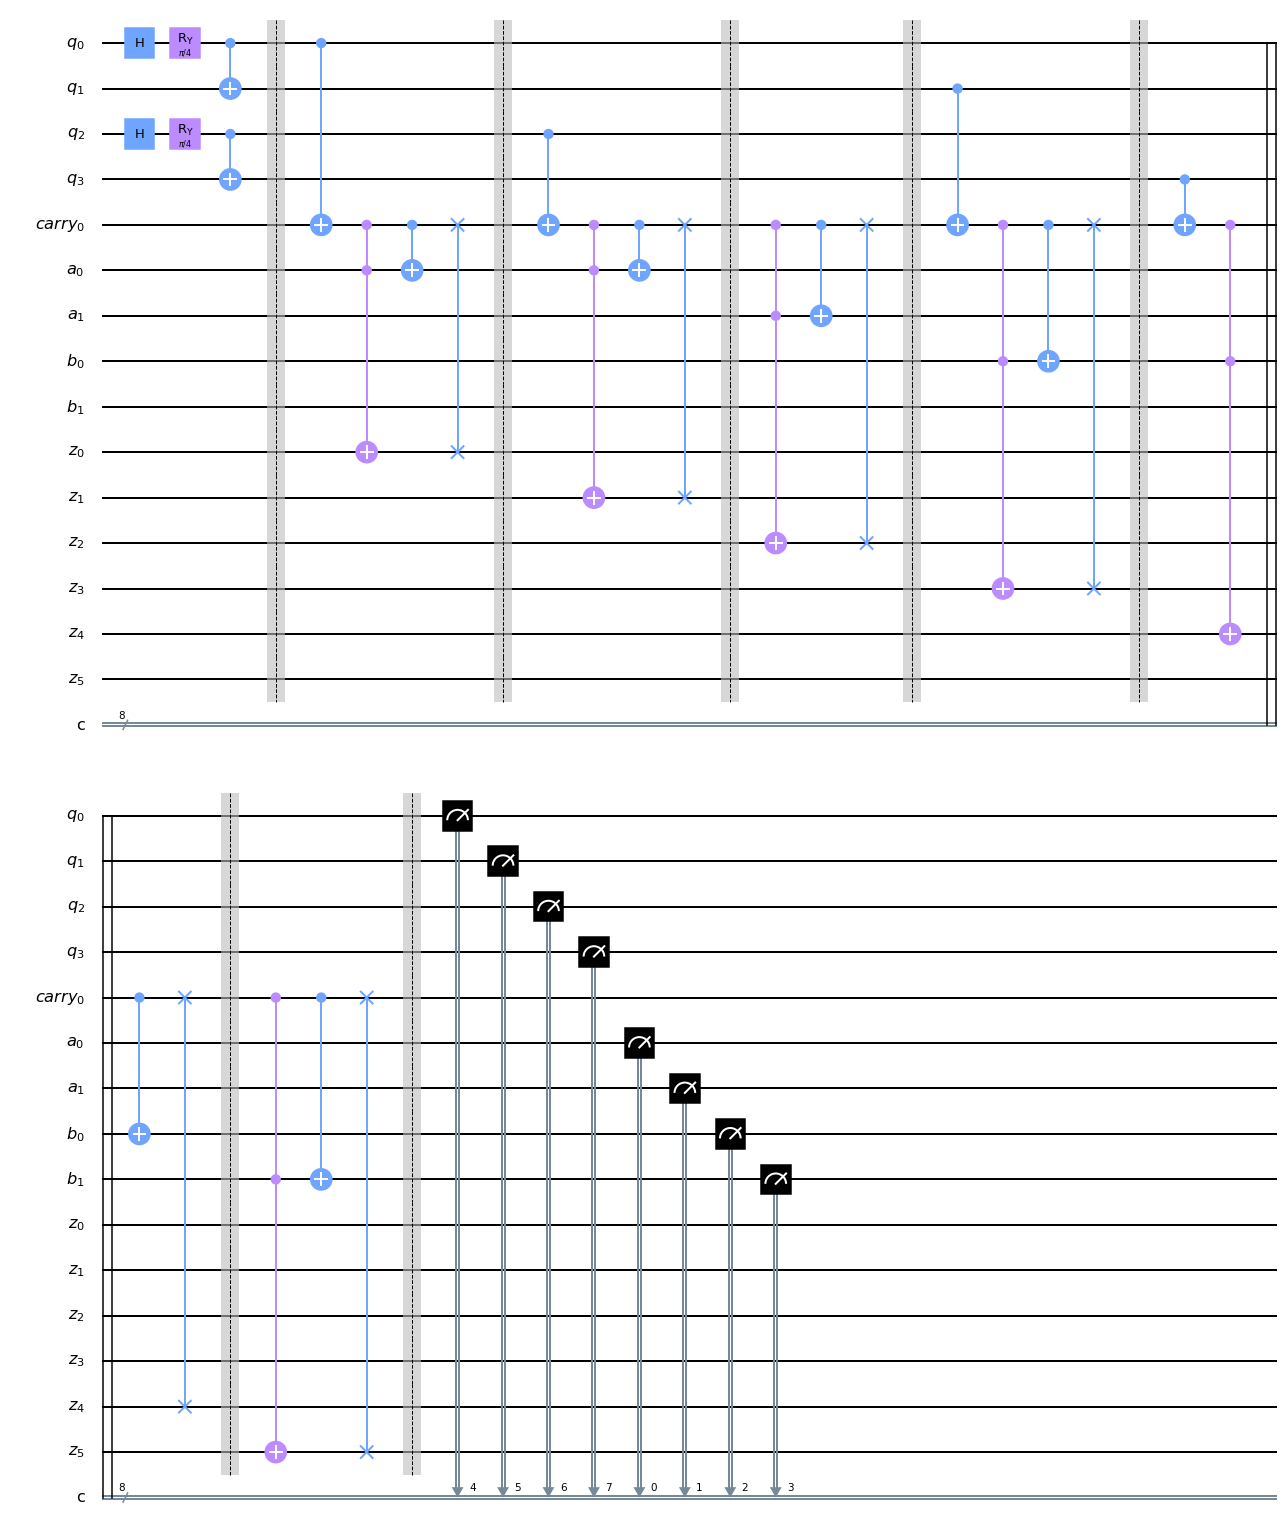

In [10]:
theta = math.pi / 4 # choose theta between -pi/2 and pi/2
N = 4 #number of states Alice and Bob begin with (first one for Alice, second one for Bob, etcetera)

# creating the initial entangled state
qr = QuantumRegister(N, 'q')
carry = QuantumRegister(1, 'carry')
ancilla_A = QuantumRegister(2, 'a')
ancilla_B = QuantumRegister(2, 'b')
zeroes = QuantumRegister(6, 'z')
cr = ClassicalRegister(8, 'c')
circuit = QuantumCircuit(qr, carry, ancilla_A, ancilla_B, zeroes, cr)
circuit.h(range(0, N, 2))
circuit.ry(theta, range(0, N, 2))
circuit.cx(range(0, N, 2), range(1, N, 2))
circuit.barrier()

hamming_weight([0, 2], carry, ancilla_A, zeroes, 0)
hamming_weight([1, 3], carry, ancilla_B, zeroes, 3)

circuit.measure([0, 1, 2, 3, 5, 6, 7, 8], [4, 5, 6, 7, 0, 1, 2, 3])
circuit.draw(output='mpl') #, filename='Elias_simulation_2.pdf'

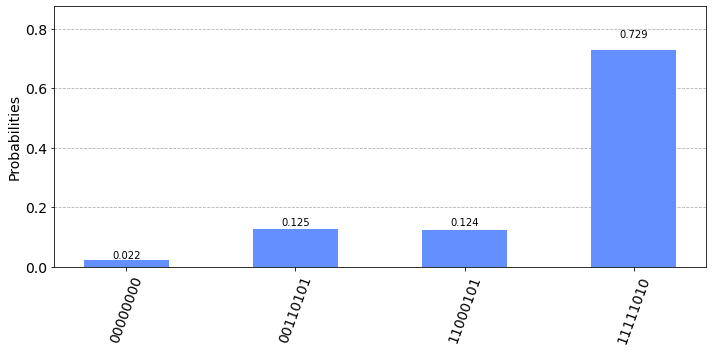

In [11]:
shots = 2**16
_, ax = plt.subplots(figsize=(10, 5))
simulator = Aer.get_backend('qasm_simulator')
results = execute(circuit, backend=simulator, shots=shots).result()
plot_histogram(results.get_counts(circuit), ax=ax)
plt.tight_layout()

# plt.savefig('Elias_simulation_2_hist_2_16_pi_3.pdf')

In [ ]:
IBMQ.load_account()

In [20]:
shots = 8192
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')
job = execute(circuit, backend=qcomp, shots=shots)

In [21]:
job_monitor(job)


Job Status: job has successfully run


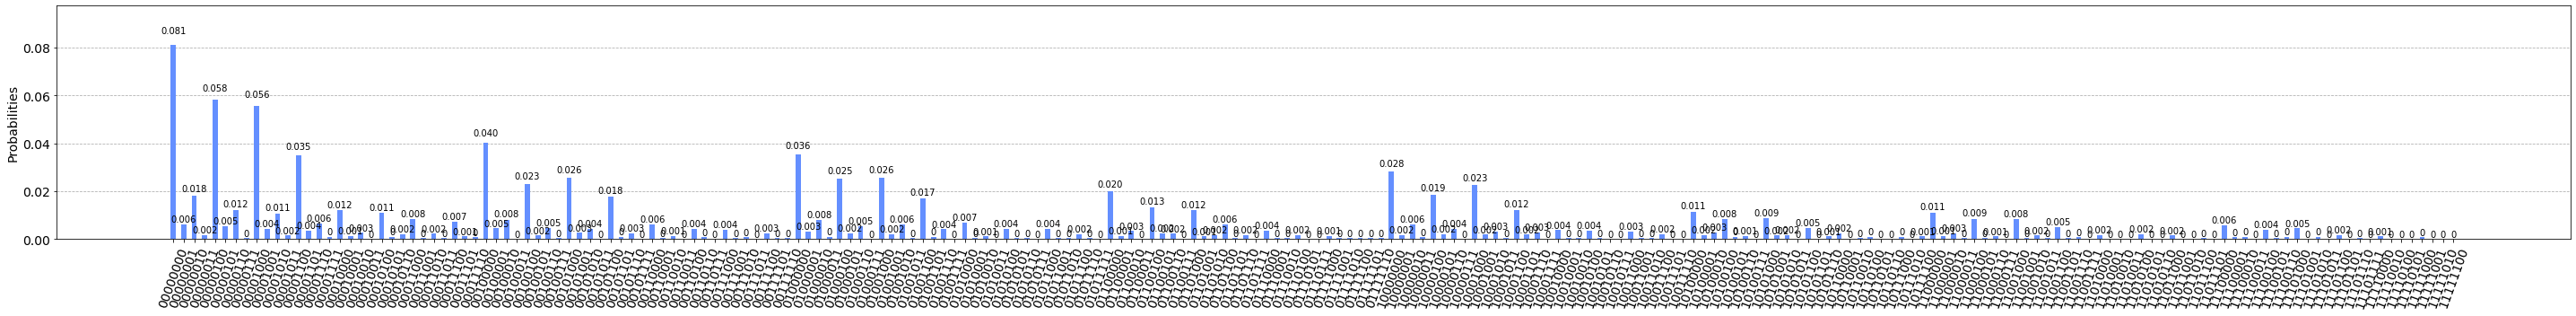

In [22]:
result = job.result()
_, ax = plt.subplots(figsize=(40, 5))
plot_histogram(result.get_counts(circuit), ax=ax)
plt.tight_layout()

plt.savefig('Elias_real_qubits_second_try_melb_pi_6_2.pdf')

______________________________________
## 3. Initial Concurrence <a id='init_conc_Elias'></a>

In the next cells we create the initial state and execute on backend Melbourne. From the results we can calculate the initial concurrence. 

In [ ]:
theta = math.pi / 3 # choose theta between -pi/2 and pi/2
N = 2 #number of states Alice and Bob begin with (first one for Alice, second one for Bob, etcetera)

# creating the initial entangled state
qr = QuantumRegister(N, 'q')
cr = ClassicalRegister(N, 'c')
circuit2 = QuantumCircuit(qr, cr)
circuit2.h(range(0, N, 2))
circuit2.ry(theta, range(0, N, 2))
circuit2.cx(range(0, N, 2), range(1, N, 2))

circuit2.measure([0, 1], [0, 1])


circuit2.draw(output='mpl')


In the next cells we run on the 15-qubit quantum processor Melbourne.

In [18]:
IBMQ.load_account()

/Users/niv/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-04-26 15:14:28,694: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
shots = 8192
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')
job = execute(circuit2, backend=qcomp, shots=shots)

In [ ]:
job_monitor(job)


In [ ]:
sns.reset_orig()
result = job.result()
_, ax = plt.subplots(figsize=(10, 5))
plot_histogram(result.get_counts(circuit2), ax=ax)
plt.tight_layout()

plt.savefig('Elias_real_qubits_init_melb_pi_3_2.pdf')